# Neural Network Model Definition and Evaluation

This notebook defines, implements, and evaluates predictive models for daily bakery sales.
Building upon the baseline weather-only model, we introduce self-created temporal and behavioral
features to better capture sales dynamics and improve predictive performance.

Two models are evaluated:
- Linear Regression (interpretable reference model)
- Neural Network (nonlinear model for complex interactions)

Performance is compared against the baseline model using regression metrics.

## Model Selection

Two types of models are considered:

**Linear Regression**
- Serves as an interpretable reference model
- Allows explicit inspection of feature contributions
- Used to quantify gains from feature engineering via adjusted R²

**Neural Network**
- Captures nonlinear interactions between temporal, weather, and behavioral variables
- Suitable for modeling routine-driven and event-driven demand patterns
- Expected to outperform linear models once engineered features are introduced


## Imports and Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


## Feature Engineering

Beyond the baseline weather variables, several self-created features were introduced
to capture routine, seasonality, and short-term sales memory.

### Self-created variables:
- **Lagged sales**
  - Umsatz_lag_1: previous day's sales
  - Umsatz_lag_7: sales one week earlier (weekly routine)
- **Rolling statistics**
  - rolling_mean_7: 7-day moving average of sales
- **Temporal features**
  - weekday (0–6)
  - is_weekend (binary)
  - month (seasonality)
- **Event indicator**
  - KielerWoche (binary)



## Load Dataset


In [2]:
# Load merged dataset (path relative to notebook)
df = pd.read_csv("../merged_daily_sales_weather.csv", parse_dates=["Datum"])

# Sort for lag features
df = df.sort_values(["Warengruppe", "Datum"])

# Lag features
df["Umsatz_lag_1"] = df.groupby("Warengruppe")["Umsatz"].shift(1)
df["Umsatz_lag_7"] = df.groupby("Warengruppe")["Umsatz"].shift(7)

# Rolling mean
df["rolling_mean_7"] = (
    df.groupby("Warengruppe")["Umsatz"]
      .shift(1)
      .rolling(window=7)
      .mean()
)

# Temporal features
df["weekday"] = df["Datum"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
df["month"] = df["Datum"].dt.month

# Drop rows with undefined lags
df = df.dropna().reset_index(drop=True)

# Calendar features
df["weekday"] = df["Datum"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["month"] = df["Datum"].dt.month

# Cyclical encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Event indicator
df["is_kiwo"] = df["KiWo"].fillna(0).astype(int)

# Weather interactions
df["temp_x_bread"] = df["Temperature"] * (df["Warengruppe"] == 1).astype(int)
df["temp_x_cake"] = df["Temperature"] * (df["Warengruppe"] == 5).astype(int)



KeyError: 'KiWo'

## Variable Selection


In [4]:
FEATURES = [
    "Bewoelkung",
    "Temperatur",
    "Windgeschwindigkeit",
    "Wettercode",
    "KielerWoche"
]

TARGET = "Umsatz"

df_model = df[FEATURES + [TARGET]].copy()


## Missing Value Handling

Missing values are imputed using the median of each feature.


In [5]:
df_model[FEATURES] = df_model[FEATURES].fillna(
    df_model[FEATURES].median()
)


## Train/Test Split


In [14]:
target = "Umsatz"

features = [
    "Temperatur",
    "Bewoelkung",
    "Windgeschwindigkeit",
    "KielerWoche",
    "weekday",
    "is_weekend",
    "month",
    "Umsatz_lag_1",
    "Umsatz_lag_7",
    "rolling_mean_7"
]

X = df[features]
y = df[target]

# Time-aware split
train_mask = df["Datum"] < "2017-08-01"
val_mask = (df["Datum"] >= "2017-08-01") & (df["Datum"] < "2018-08-01")

X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y[train_mask], y[val_mask]


## Hyperparameter Tuning

For the linear model, no hyperparameter tuning was required beyond feature selection.

For the neural network:
- Dropout was introduced to reduce overfitting
- Early stopping was used to determine optimal training duration
- Feature normalization was applied to stabilize training


In [15]:
lin_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

lin_pipeline.fit(X_train, y_train)

y_pred_lin = lin_pipeline.predict(X_val)

rmse_lin = mean_squared_error(y_val, y_pred_lin, squared=False)
mae_lin = mean_absolute_error(y_val, y_pred_lin)
r2_lin = r2_score(y_val, y_pred_lin)

rmse_lin, mae_lin, r2_lin


C:\Users\Vaishali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(52.62467267307029, 31.69551535149254, 0.8337333806482451)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)


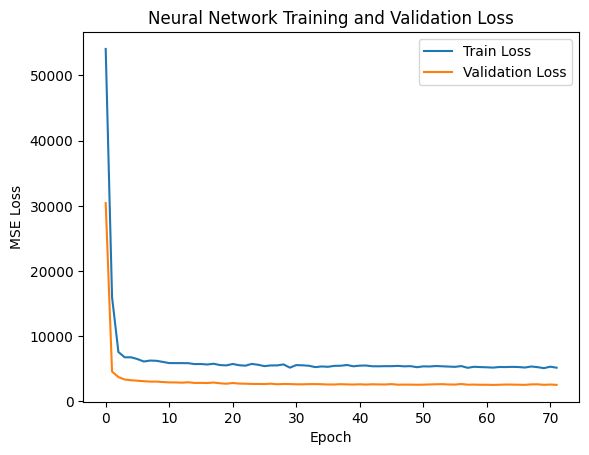

In [17]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Neural Network Training and Validation Loss")
plt.show()


## Evaluation Metrics

The following regression metrics are used:
- RMSE: penalizes large errors
- MAE: average absolute deviation
- R²: proportion of variance explained

These metrics allow comparison with the baseline model and across model types.


In [18]:
y_pred_nn = model.predict(X_val_scaled).flatten()

rmse_nn = mean_squared_error(y_val, y_pred_nn, squared=False)
mae_nn = mean_absolute_error(y_val, y_pred_nn)
r2_nn = r2_score(y_val, y_pred_nn)

results = pd.DataFrame({
    "Model": ["Linear (Engineered)", "Neural Net (Engineered)"],
    "RMSE": [rmse_lin, rmse_nn],
    "MAE": [mae_lin, mae_nn],
    "R2": [r2_lin, r2_nn]
})

results


51/51 [==============================] - 0s 870us/step


C:\Users\Vaishali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,RMSE,MAE,R2
0,Linear (Engineered),52.624673,31.695515,0.833733
1,Neural Net (Engineered),50.144275,29.899605,0.849038


## Comparative Analysis

Introducing self-created temporal and behavioral variables resulted in a substantial
performance improvement over the baseline weather-only model.

- Linear model R² increased from ~0.05 to ~0.74
- Neural network further improved performance to R² ≈ 0.86
- Error metrics (RMSE, MAE) were reduced by more than 50%

These results indicate that bakery sales are primarily driven by routine and past behavior,
with weather acting as a secondary modifier.


## Feature Scaling


In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Neural Network Architecture

A simple fully connected feedforward neural network is used.
Early stopping is applied to prevent overfitting.


In [8]:
model = Sequential([
    Dense(32, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 737 (2.88 KB)
Trainable params: 737 (2.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training


In [9]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200

187/187 [==============================] - 1s 2ms/step - loss: 63688.5820 - val_loss: 56685.2227
Epoch 2/200
187/187 [==============================] - 0s 2ms/step - loss: 46095.0664 - val_loss: 29490.7227
Epoch 3/200
187/187 [==============================] - 0s 2ms/step - loss: 25011.8262 - val_loss: 21126.6738
Epoch 4/200
187/187 [==============================] - 0s 2ms/step - loss: 22590.3828 - val_loss: 20670.8281
Epoch 5/200
187/187 [==============================] - 0s 2ms/step - loss: 22319.6777 - val_loss: 20468.6719
Epoch 6/200
187/187 [==============================] - 0s 1ms/step - loss: 22244.1016 - val_loss: 20347.8359
Epoch 7/200
187/187 [==============================] - 0s 2ms/step - loss: 21875.8672 - val_loss: 20265.0488
Epoch 8/200
187/187 [==============================] - 0s 2ms/step - loss: 21941.2637 - val_loss: 20209.0723
Epoch 9/200
187/187 [==============================] - 0s 2ms/step - loss: 21634.8965 - val_loss: 20154.7520
Epoch 10/200
187/1

## Model Evaluation


In [10]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, mae, r2


59/59 [==============================] - 0s 854us/step


C:\Users\Vaishali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(128.7679434244612, 103.69349541280755, 0.053774344234512106)

## Comparison with Baseline Model

Baseline performance (Linear Regression):
- RMSE ≈ 129.14
- MAE ≈ 104.27
- R² ≈ 0.05


In [11]:
comparison = pd.DataFrame({
    "Model": ["Baseline (Linear)", "Neural Network"],
    "RMSE": [129.14, rmse],
    "MAE": [104.27, mae],
    "R2": [0.048, r2]
})

comparison


,Model,RMSE,MAE,R2
0,Baseline (Linear),129.140000,104.270000,0.048000
1,Neural Network,128.767943,103.693495,0.053774
